In [1]:
#!pip install sklearn
#!pip install bcml4pheno
#!pip install tensorflow 

In [2]:
import os
import csv
import math 
import numpy as np
import pandas as pd
import ROOT
from bcml4pheno import bcml_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.26/06


2022-08-31 19:59:16.477771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 19:59:16.477799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def read_csv(folder, name):
    dict_={}
    ax=next(os.walk(folder))[2]
    ax.sort(reverse = True )
    for file in ax:
        if "Cutflow" in file: continue
        elif name in file:
            df=pd.read_csv(
                os.path.join(folder,file)
            )
            dict_.update(
                {file.removesuffix(f"_{name}") : df}
            )
    return dict_

def load_all_csv(folder):
    data_dict={}
    results_names=[
        #zero jets selection
        "b_tau_tau_hadronic_zero_jets",
        #At Least one jet
        "b_tau_tau_hadronic_(al)one_jet",
        #double leptoquark selection
        "b_b_tau_tau_hadronic"
    ]
    for name in results_names:
        data_dict.update({name: read_csv(folder,f"{name}.csv")})
    return data_dict

In [4]:
def prepare_features(data_dict,name='',channel=""):
    signal_feature=[]
    for i in range(data_dict[channel][name].shape[0]):
        row=[]
        
        row+=[data_dict[channel][name]['MET(GeV)'][i]]
        row+=[data_dict[channel][name]['#phi_{MET}'][i]]
        
        #row+=[data_dict[channel][name]['m_{j_{1}}(GeV)'][i]]
        #row+=[data_dict[channel][name]['pT_{j_{1}}(GeV)'][i]]
        #row+=[data_dict[channel][name]['#phi_{j_{1}}'][i]]
        #row+=[data_dict[channel][name]['#eta_{j_{1}}'][i]]
        
        row+=[data_dict[channel][name]['m_{b_{1}}(GeV)'][i]]
        row+=[data_dict[channel][name]['pT_{b_{1}}(GeV)'][i]]
        row+=[data_dict[channel][name]['#phi_{b_{1}}'][i]]
        row+=[data_dict[channel][name]['#eta_{b_{1}}'][i]]
        
        row+=[data_dict[channel][name]['m_{#tau_{1}}(GeV)'][i]]
        row+=[data_dict[channel][name]['pT_{#tau_{1}}(GeV)'][i]]
        row+=[data_dict[channel][name]['#phi_{#tau_{1}}'][i]]
        row+=[data_dict[channel][name]['#eta_{#tau_{1}}'][i]]
        
        row+=[data_dict[channel][name]['m_{#tau_{2}}(GeV)'][i]]
        row+=[data_dict[channel][name]['pT_{#tau_{2}}(GeV)'][i]]
        row+=[data_dict[channel][name]['#phi_{#tau_{2}}'][i]]
        row+=[data_dict[channel][name]['#eta_{#tau_{2}}'][i]]
        
        signal_feature.append(row)
    return np.array(signal_feature)

def concat_signals(data_dict,signal_list,channel):
    names=signal_list.copy()
    name_0=names.pop(0)
    arr=prepare_features(data_dict,name_0,channel)[:,:]
    for name in names:
        arr=np.concatenate((arr,prepare_features(data_dict,name,channel)[:,:]))
    np.random.shuffle(arr)
    return arr

def concat_channels(data_dict,signal_list,channels):
    chs=channels.copy()
    ch_0=chs.pop(0)
    arr=concat_signals(data_dict,signal_list,ch_0)
    for channel in chs:
        arr=np.concatenate((arr,concat_signals(data_dict,signal_list,channel)[:,:]))
    np.random.shuffle(arr)
    return arr

In [5]:
def prepare_to_train (signal,bkg):
    bkg_vsize=min([len(signal),len(bkg)])
    signal_vsize=bkg_vsize

    pred=signal[:signal_vsize, :]
    pred=np.concatenate((pred,bkg[:bkg_vsize, :]))
    
    labels=np.zeros(np.shape(pred)[0])
    labels[:signal_vsize] = 1
    
    return pred , labels

In [6]:
folder_out=os.path.join(os.getcwd(),"03_delphes_analysis")
data_dict=load_all_csv(os.path.join(folder_out,"csv_files"))
print(data_dict.keys())
a=list(data_dict["b_tau_tau_hadronic_zero_jets"]["ttbar"])
a.sort( reverse = True)
a

dict_keys(['b_tau_tau_hadronic_zero_jets', 'b_tau_tau_hadronic_(al)one_jet', 'b_b_tau_tau_hadronic'])


['pT_{b_{1}}(GeV)',
 'pT_{#tau_{2}}(GeV)',
 'pT_{#tau_{1}}(GeV)',
 'm_{b_{1}}(GeV)',
 'm_{#tau_{2}}(GeV)',
 'm_{#tau_{1}}(GeV)',
 'MET(GeV)',
 '#phi_{b_{1}}',
 '#phi_{MET}',
 '#phi_{#tau_{2}}',
 '#phi_{#tau_{1}}',
 '#eta_{b_{1}}',
 '#eta_{#tau_{2}}',
 '#eta_{#tau_{1}}',
 '#Delta{pT}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{R}_{b_{1}#tau_{2}}',
 '#Delta{R}_{b_{1}#tau_{1}}',
 '#Delta{R}_{#tau_{1}#tau_{2}}',
 '#Delta{#vec{p}}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{p}}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{pT}}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{pT}}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{#phi}_{b_{1}#tau_{2}}',
 '#Delta{#phi}_{b_{1}#tau_{1}}',
 '#Delta{#phi}_{#tau_{1}#tau_{2}}',
 '#Delta{#eta}_{b_{1}#tau_{2}}',
 '#Delta{#eta}_{b_{1}#tau_{1}}',
 '#Delta{#eta}_{#tau_{1}#tau_{2}}']

In [7]:
def get_yield(df,signal_list):
    xs={}#pb

    xs["LQ_LQ_0250"]=937.9
    xs["Tau_LQ_Merged_0250"]=1.273715e+02
    xs["Tau_LQ_0250"]=1.06*1.273715e+02

    xs["LQ_LQ_0500"]=20.02
    xs["Tau_LQ_Merged_0500"]=4.426293e+00  
    xs["Tau_LQ_0500"]=1.06*4.426293e+00  


    xs["LQ_LQ_0750"]=1.527
    xs["Tau_LQ_Merged_0750"]=4.745375e-01
    xs["Tau_LQ_0750"]=1.06*4.745375e-01


    xs["LQ_LQ_1000"]=0.19567
    xs["Tau_LQ_Merged_1000"]=8.456951e-02
    xs["Tau_LQ_1000"]=1.06*8.456951e-02

    xs["LQ_LQ_1250"]=0.0330183
    xs["Tau_LQ_Merged_1250"]=1.958535e-02
    xs["Tau_LQ_1250"]=1.06*1.958535e-02


    xs["LQ_LQ_1500"]=0.00654102
    xs["Tau_LQ_Merged_1500"]=5.384594e-03
    xs["Tau_LQ_1500"]=1.06*5.384594e-03


    xs["LQ_LQ_1750"]=0.001428408
    xs["Tau_LQ_Merged_1750"]=1.676315e-03
    xs["Tau_LQ_1750"]=1.06*1.676315e-03


    xs["LQ_LQ_2000"]=0.000331919
    xs["Tau_LQ_Merged_2000"]=5.671019e-04
    xs["Tau_LQ_2000"]=1.06*5.671019e-04

    xs["LQ_LQ_2250"]=8.02268e-05
    xs["Tau_LQ_Merged_2250"]=2.058213e-04
    xs["Tau_LQ_2250"]=1.06*2.058213e-04

    xs["LQ_LQ_2500"]=1.997652e-05
    xs["Tau_LQ_Merged_2500"]=7.692398e-05
    xs["Tau_LQ_2500"]=1.06*7.692398e-05

    xs["w_jets"]=1.465483e+05
    xs["z_jets"]=4.302927e+04

    xs["ttbar"]=5.046960e+02
    xs["stop"]=241.2

    xs["ww"]=6.550736e+01
    xs["wz"]=2.469184e+01
    xs["zz"]=9.562416e+00
    yields=0
    for name in signal_list:
        yields+=df[name][(df.shape[0]-1)]*xs[name]*137*1000
    return yields

In [8]:
channel="b_tau_tau_hadronic_(al)one_jet"
df=pd.read_csv(os.path.join(folder_out,f"Cutflow_{channel}.csv"))

In [9]:
name="Tau_LQ_Merged_2000"
signal_names=[name]
bkg_names=["ttbar","stop","z_jets","w_jets","ww","wz","zz"]
signal= concat_signals(data_dict,signal_names,channel)
bkg= concat_signals(data_dict,bkg_names,channel)

In [10]:
sig_yield=get_yield(df,signal_names)
bkg_yield=get_yield(df,bkg_names)

print(sig_yield)
print(bkg_yield)

4.320425837195509
227162.5391789593


In [11]:
pred1 , labels1= prepare_to_train(signal,bkg)
trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.01)

logreg_model = bcml_model(
    make_pipeline(
        StandardScaler(), 
        LogisticRegression()
    )
)

logreg_model.fit(trainPred, trainLab)

In [12]:
tpr=logreg_model.tpr(testLab, preds=testPred)
tpr

0.9814814814814815

In [13]:
fpr=logreg_model.fpr(testLab, preds=testPred)
fpr

0.0

In [14]:
print(sig_yield*tpr)
print(bkg_yield*fpr)

4.240417951321517
0.0


In [15]:
logreg_model.significance(sig_yield,bkg_yield, tpr=tpr, fpr=fpr, sepbg=False)

2.0592275132246844

In [16]:
m=logreg_model
mass=1500
sig_default=m.significance(sig_yield,bkg_yield, tpr=m.tpr(testLab, preds=testPred), fpr=m.fpr(testLab, preds=testPred), sepbg=False)
logreg_opt_results_nosepbg = m.best_threshold(sig_yield, bkg_yield, testPred, testLab, sepbg=False) 
sig_opt=logreg_opt_results_nosepbg[1]
print(f'the default significance for SingleLQ_%s'% mass+ " is: %s" % sig_default)
print(f'the maximum significance for SingleLQ_%s'% mass+ " is: %s" % sig_opt)

the default significance for SingleLQ_1500 is: 2.0592275132246844
the maximum significance for SingleLQ_1500 is: 2.0592275132246844


In [17]:
from ROOT import TH1F, TCanvas, TGraph

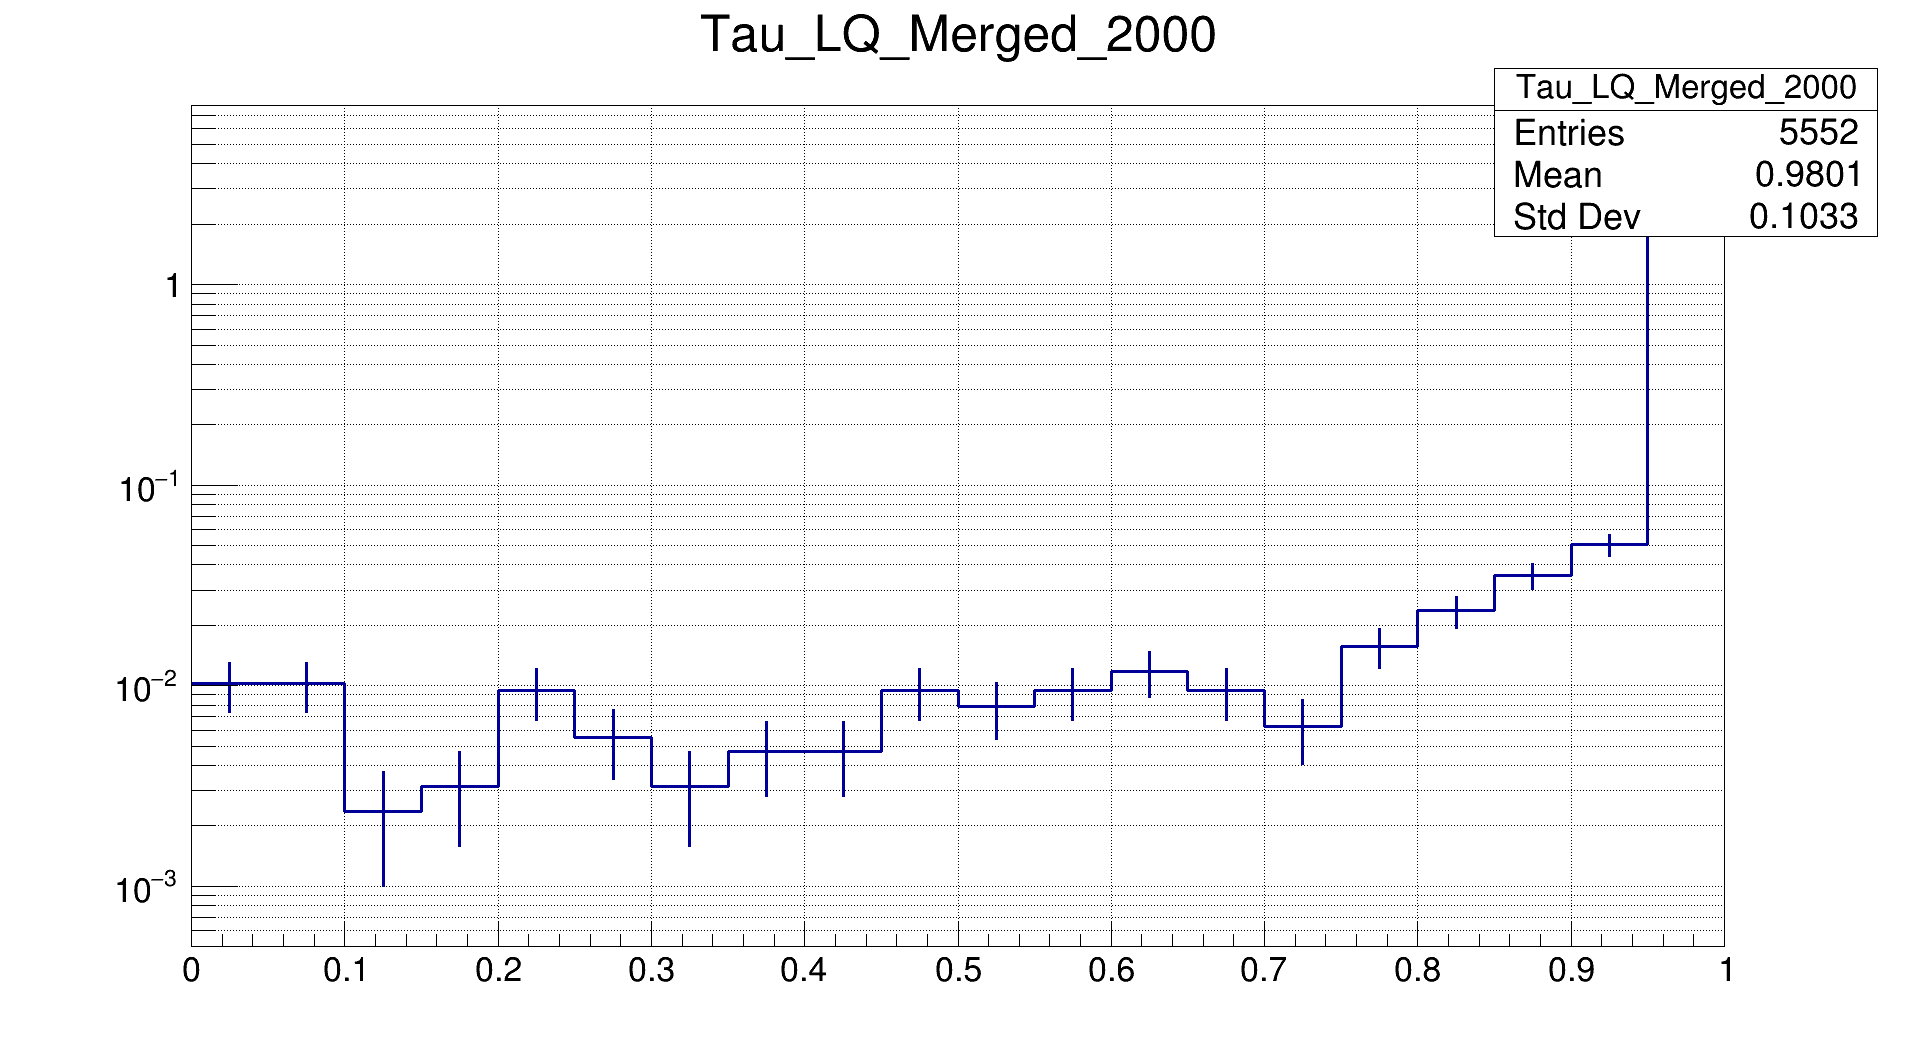

In [18]:

c1 = TCanvas( f'c-{name}', '', 0, 0, 1920, 1080)
c1.SetGrid()
c1.SetLogy()
h = TH1F(name, name, 20, 0.0,1.0)
h.SetLineWidth(3)
for score in logreg_model.predict_proba(concat_signals(data_dict,[name],channel)):
    h.Fill(score)
h.Scale(get_yield(df,[name])/h.Integral())
h.Draw("H")
c1.Draw()

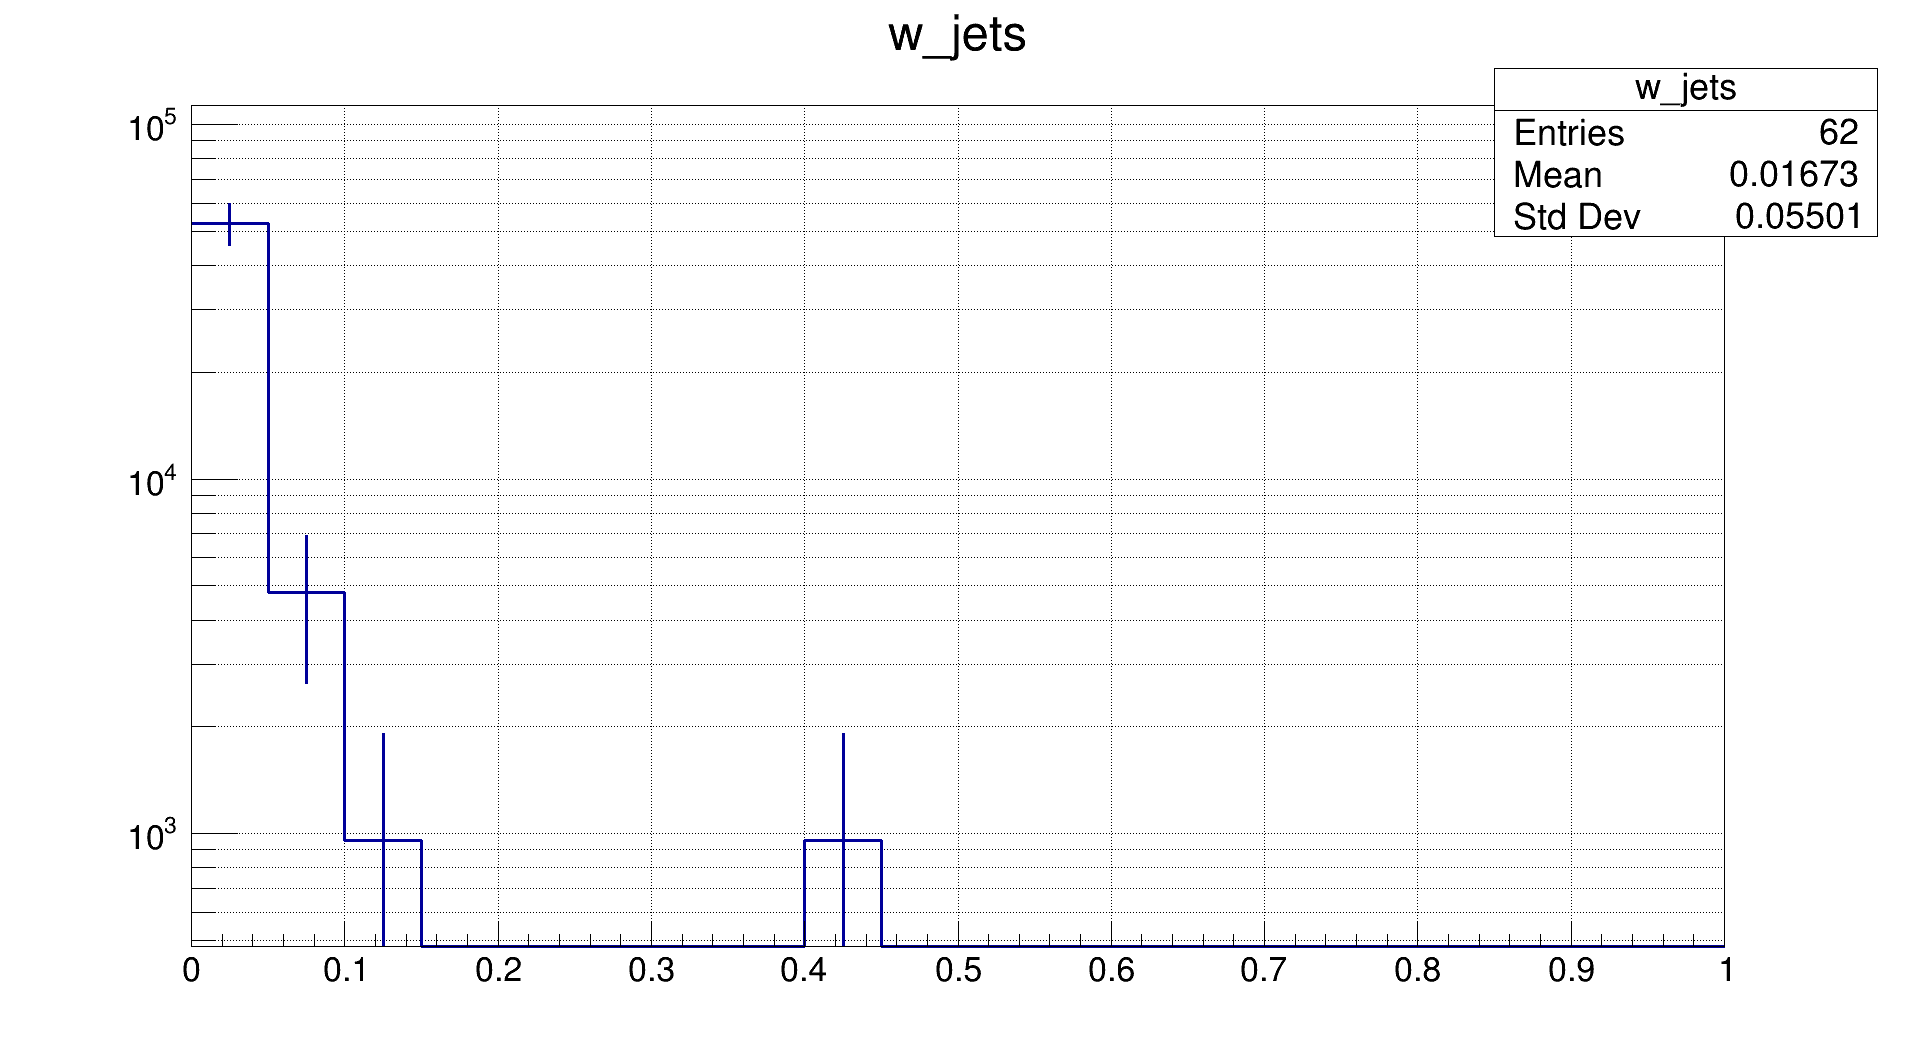

In [19]:
name="w_jets"
c1 = TCanvas( f'c-{name}', '', 0, 0, 1920, 1080)
c1.SetGrid()
c1.SetLogy()
h = TH1F(name, name, 20, 0.0,1.0)
h.SetLineWidth(3)
for score in logreg_model.predict_proba(concat_signals(data_dict,[name],channel)):
    h.Fill(score)
h.Scale(get_yield(df,[name])/h.Integral())
h.Draw("H")
c1.Draw()

In [20]:
def Draw_Discrtiminator(name):
    c1 = TCanvas( f'c-{name}', '', 0, 0, 1280, 720)
    c1.SetGrid()
    c1.SetLogy()
    h = TH1F(name, name, 100, 0.0,1.0)
    h.SetDirectory(0)
    h.SetLineWidth(3)
    for score in logreg_model.predict_proba(concat_signals(data_dict,[name],channel)):
        h.Fill(score)
    h.Scale(get_yield(df,[name])/h.Integral())
    h.Draw("H")
    c1.SaveAs(os.path.join(folder_out,f"{name}_discriminator_hadronic_j.png"))
    return (name,h)

In [21]:
signal_names.append("LQ_LQ_1500")

histograms=dict(map(Draw_Discrtiminator,signal_names+bkg_names))


Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/Tau_LQ_Merged_2000_discriminator_hadronic_j.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/LQ_LQ_1500_discriminator_hadronic_j.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/ttbar_discriminator_hadronic_j.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/stop_discriminator_hadronic_j.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/z_jets_discriminator_hadronic_j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c-w_jets
Warning in <TROOT::Append>: Replacing existing TH1: w_jets (Potential memory leak).
Info in <TCanvas::Print>: png file /home/c

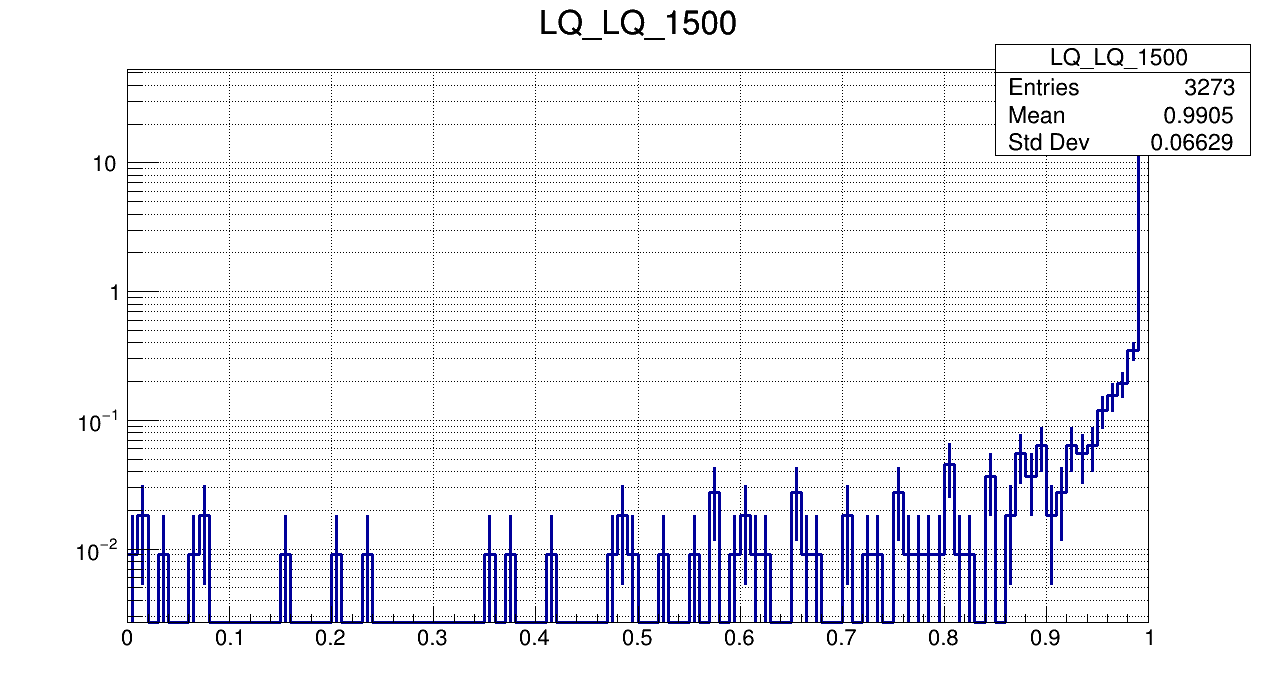

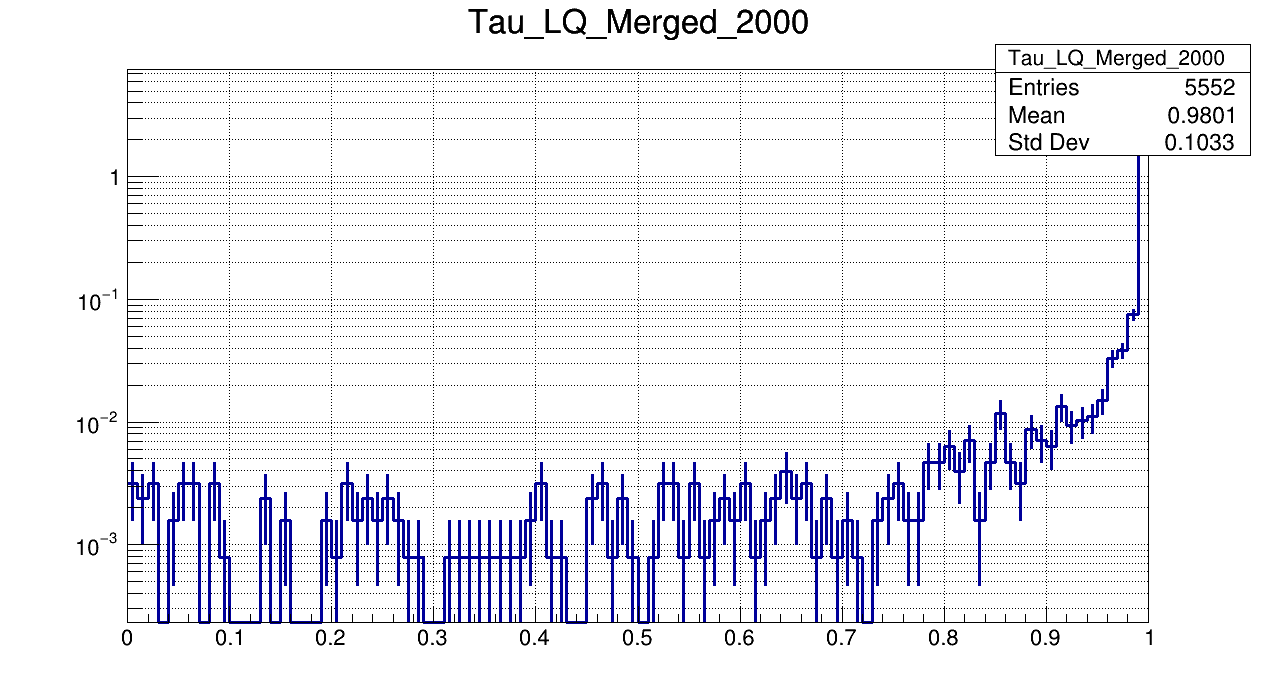

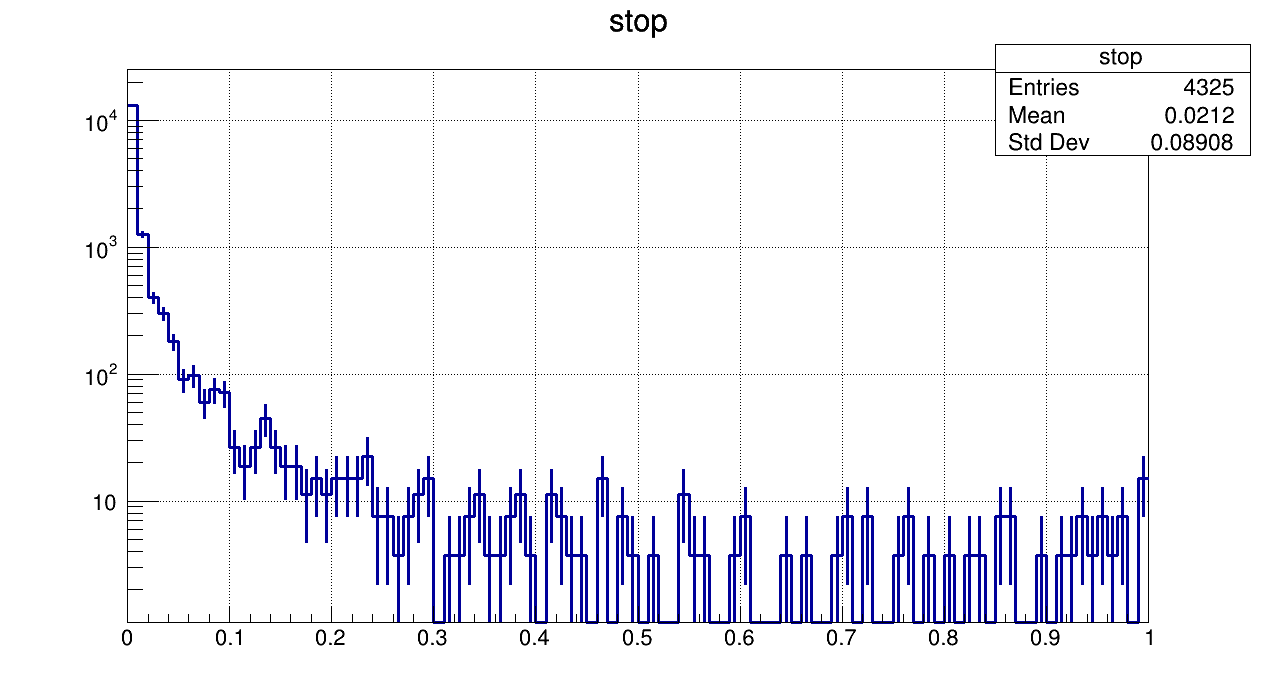

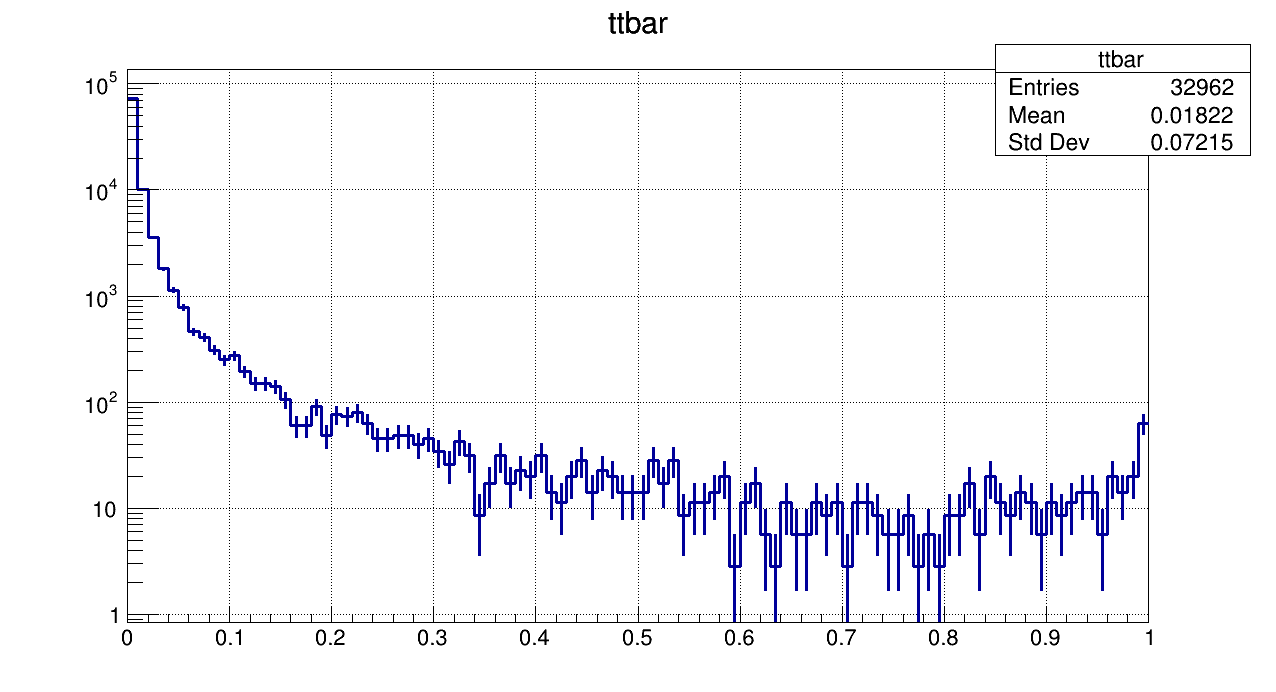

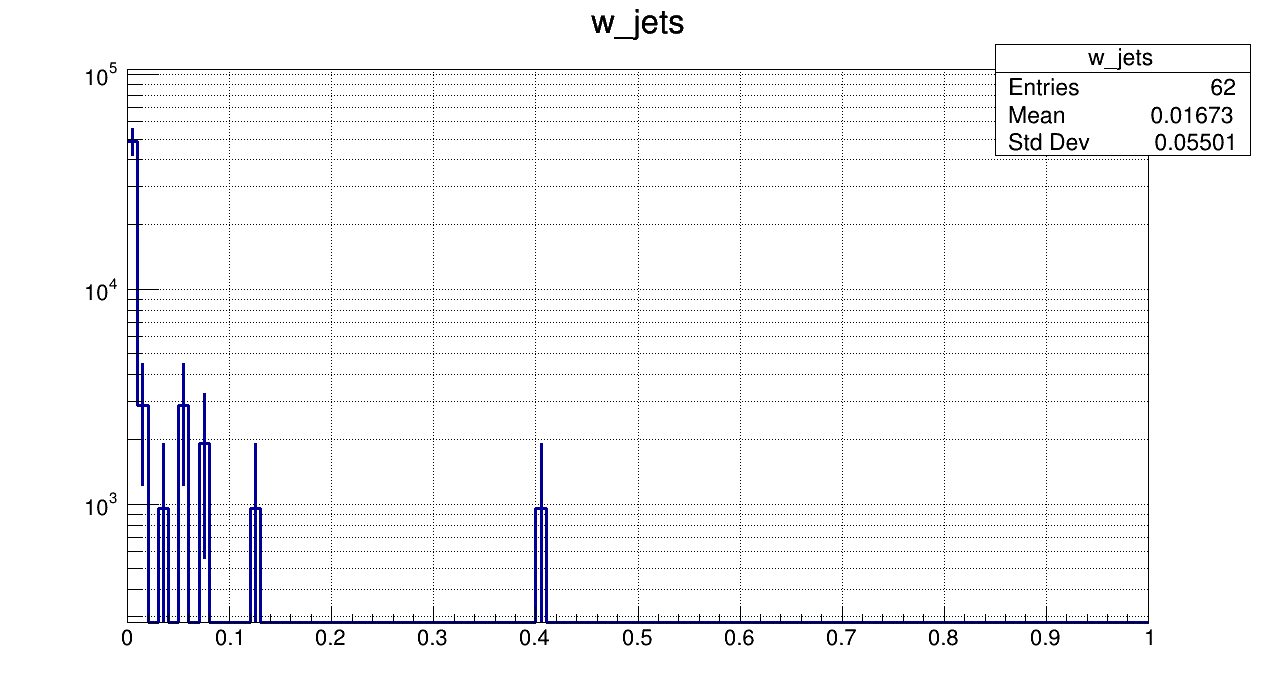

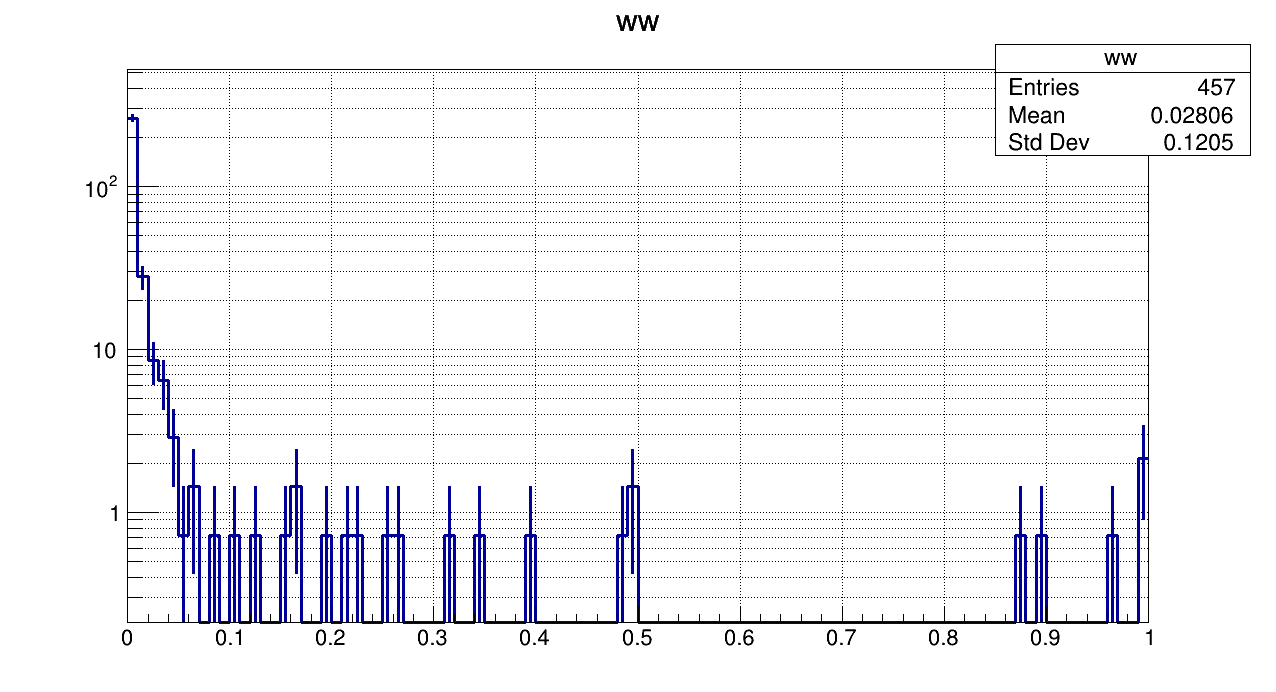

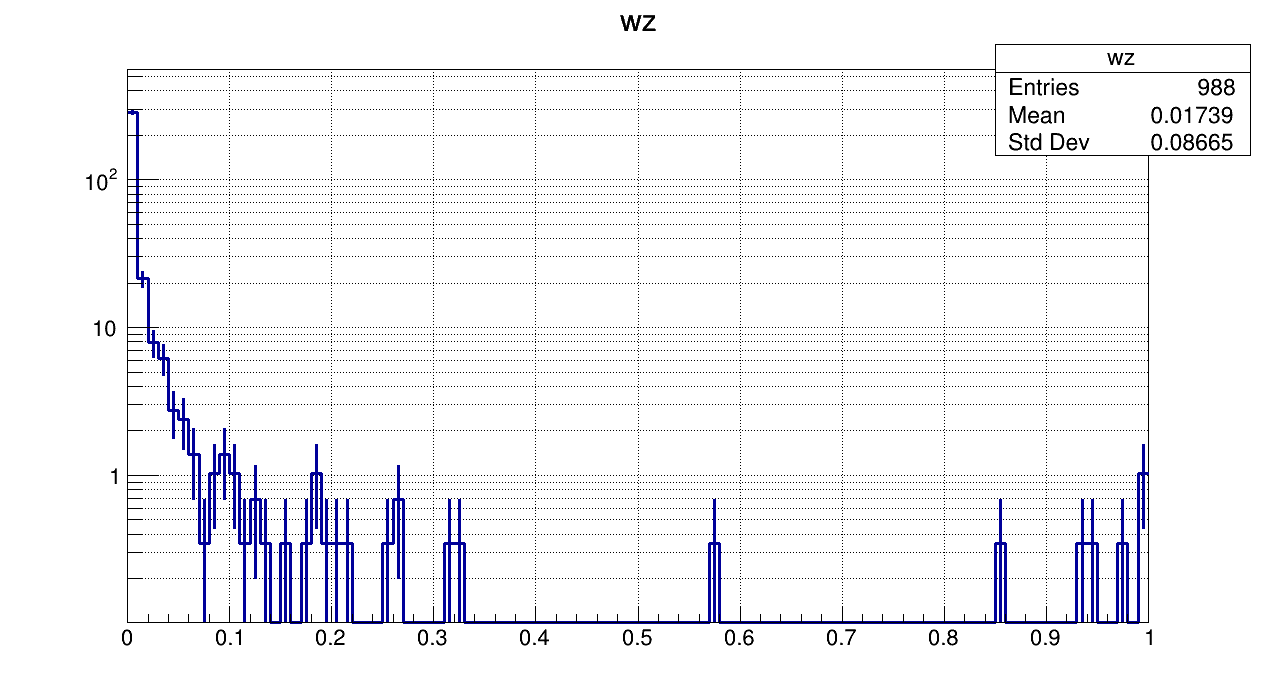

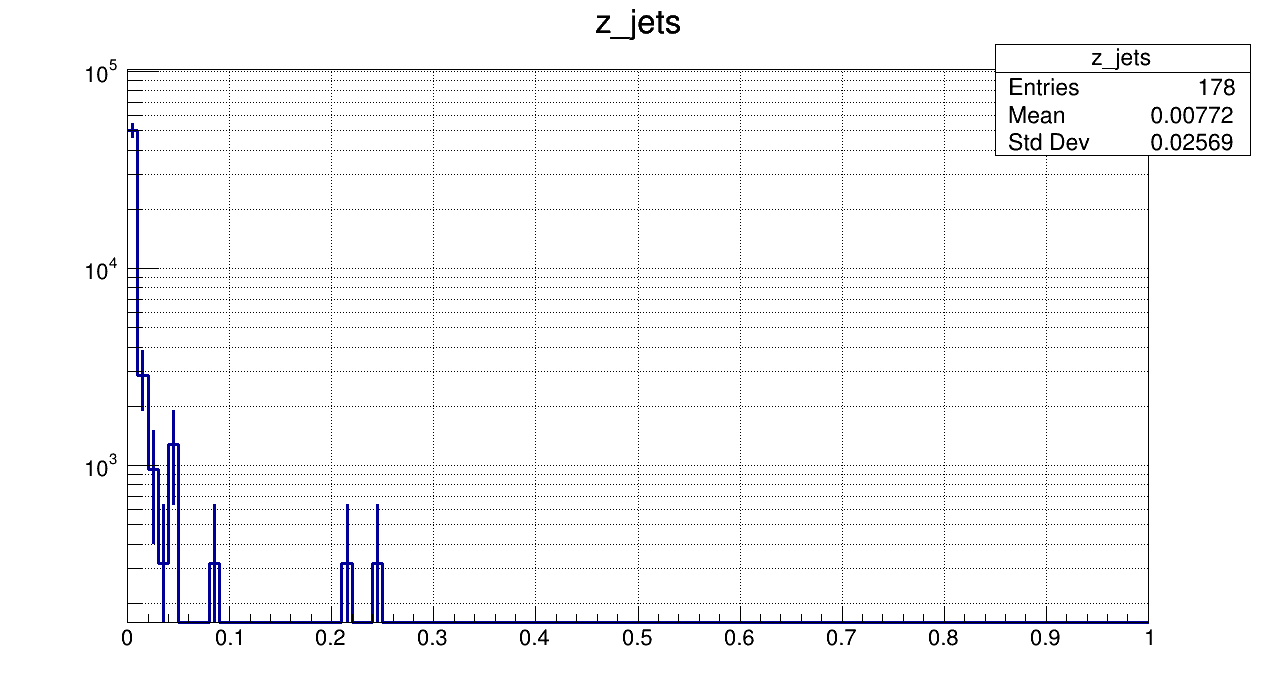

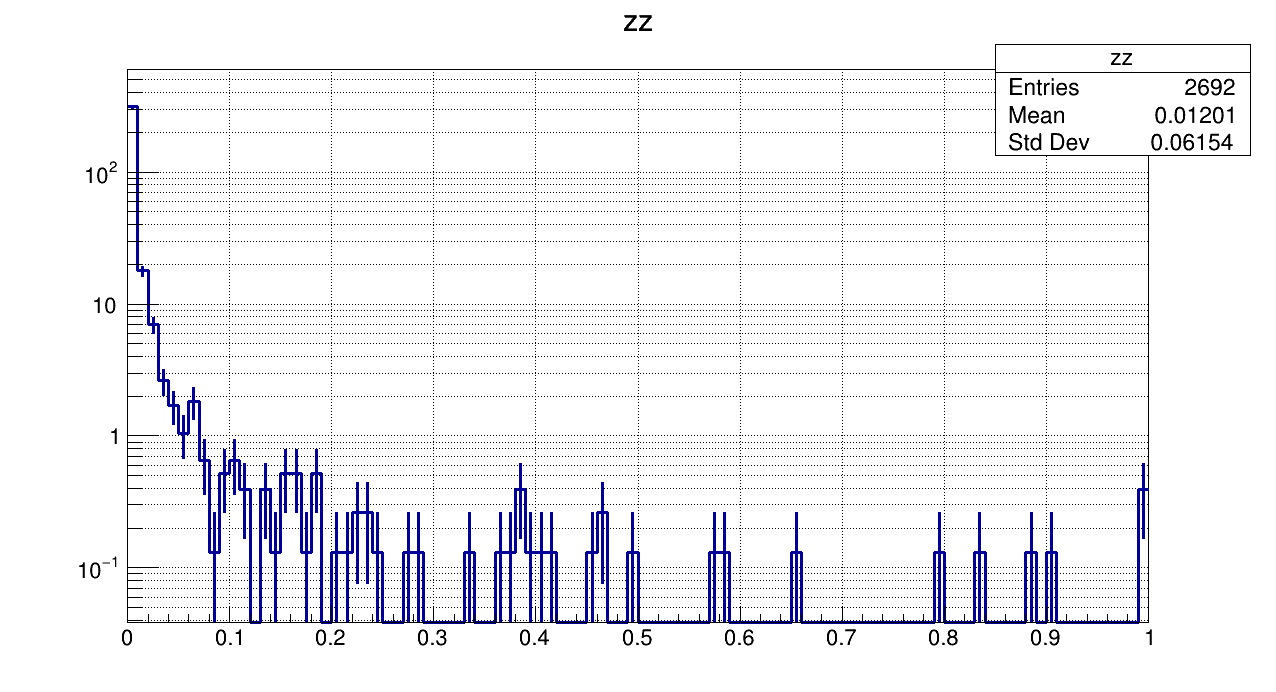

In [22]:
from IPython.display import Image, display
listOfImageNames=[]
files=next(os.walk(folder_out))[2]
for file in files:
    if "_j.png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=os.path.join(folder_out,imageName)))

In [23]:
histograms

{'Tau_LQ_Merged_2000': <cppyy.gbl.TH1F object at 0x564d70a2b150>,
 'LQ_LQ_1500': <cppyy.gbl.TH1F object at 0x564d70a109e0>,
 'ttbar': <cppyy.gbl.TH1F object at 0x564d70a16270>,
 'stop': <cppyy.gbl.TH1F object at 0x564d7096fa00>,
 'z_jets': <cppyy.gbl.TH1F object at 0x564d7099e1e0>,
 'w_jets': <cppyy.gbl.TH1F object at 0x564d79920e90>,
 'ww': <cppyy.gbl.TH1F object at 0x564d7a17eed0>,
 'wz': <cppyy.gbl.TH1F object at 0x564d799a3d70>,
 'zz': <cppyy.gbl.TH1F object at 0x564d79997600>}

In [24]:
threshold=0.99

In [25]:
h=histograms[name]
gbin1=h.FindBin(threshold)
gbin2=h.GetMaximumBin()
h.Integral(gbin1,gbin2)

0.0

In [26]:
h=histograms["LQ_LQ_1500"]
gbin1=h.FindBin(threshold)
gbin2=h.GetMaximumBin()
h.Integral(gbin1,gbin2)

27.620834350585938

In [27]:
actual_signal_yield=0
for name in signal_names:
    h=histograms[name]
    gbin1=h.FindBin(threshold)
    gbin2=h.GetMaximumBin()
    actual_signal_yield+=h.Integral(gbin1,gbin2)
print(signal_names,actual_signal_yield)

['Tau_LQ_Merged_2000', 'LQ_LQ_1500'] 31.54649257659912


In [28]:
actual_bkg_yield=0
for name in bkg_names:
    h=histograms[name]
    gbin1=h.FindBin(threshold)
    gbin2=h.GetMaximumBin()
    actual_bkg_yield+=h.Integral(gbin1,gbin2)
print(bkg_names,actual_bkg_yield)

['ttbar', 'stop', 'z_jets', 'w_jets', 'ww', 'wz', 'zz'] 81.17761769890785


In [29]:
significance=actual_signal_yield/math.sqrt(actual_signal_yield+actual_bkg_yield)
significance

2.9712737911954825

In [30]:
def get_yield_by_names(hists,names,threshold):
    signal_yield=0
    for name in names:
        h=hists[name]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetMaximumBin()
        signal_yield+=h.Integral(gbin1,gbin2)
    return signal_yield

In [31]:
def get_sig_by_threshold(histos,threshold=0.5):
    actual_signal_yield=get_yield_by_names(histos,signal_names,threshold)
    actual_bkg_yield=get_yield_by_names(histos,bkg_names,threshold)
    return int(actual_signal_yield)/math.sqrt(int(actual_signal_yield)+int(actual_bkg_yield)+1e-3)

In [32]:
get_sig_by_threshold(histograms,0.99)

2.9292115890132493

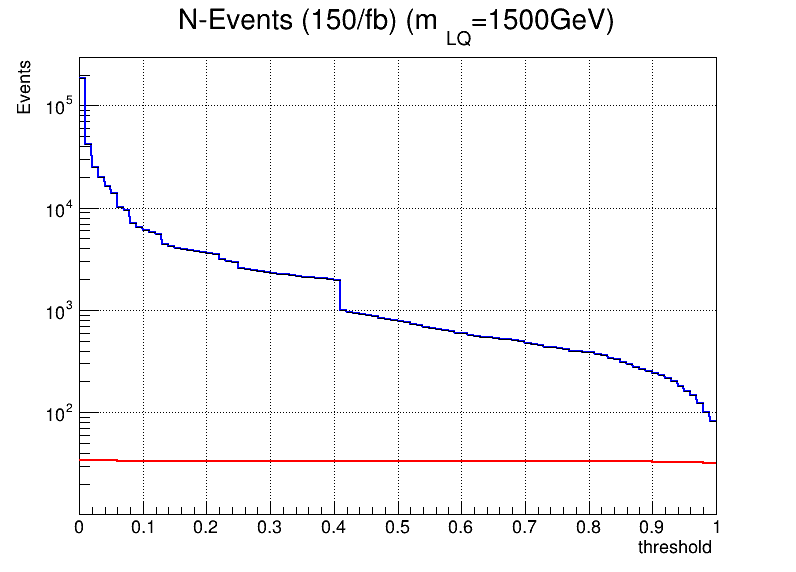

In [33]:
x=[]
y1=[]
y2=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y1+=[get_yield_by_names(histograms,bkg_names,x[i])]
    y2+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y1  = np.array(  y1 )
y2  = np.array(  y2 )

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph1=TGraph(n, x, y1)
graph1.SetTitle("N-Events (150/fb) (m_{LQ}=1500GeV);threshold; Events")
graph1.GetXaxis().SetLimits(0,1)
graph1.GetHistogram().SetMinimum(10)
graph1.GetHistogram().SetMaximum(3e5)
graph1.Draw("ALP")
graph1.SetLineColor(ROOT.kBlue)
graph1.SetLineWidth(2)

graph2=TGraph(n, x, y2)
graph2.Draw("l-same")
graph2.SetLineColor(ROOT.kRed)
graph2.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


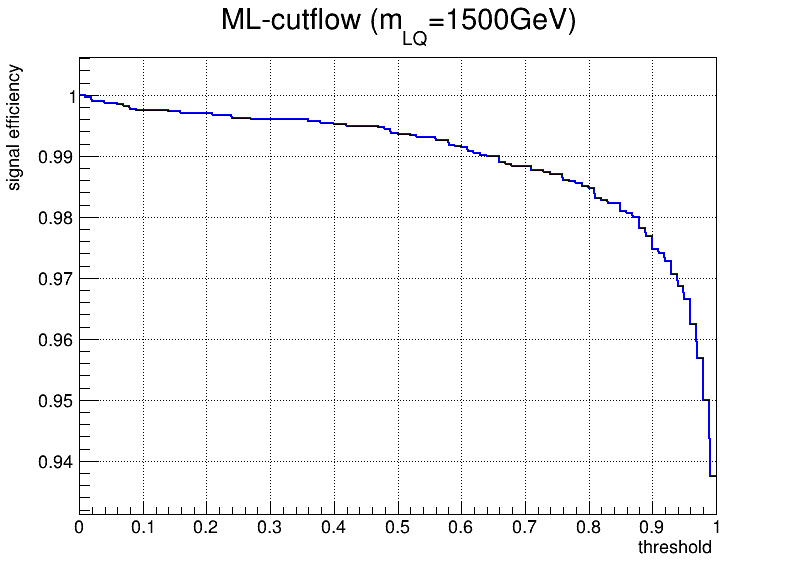

In [34]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;signal efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


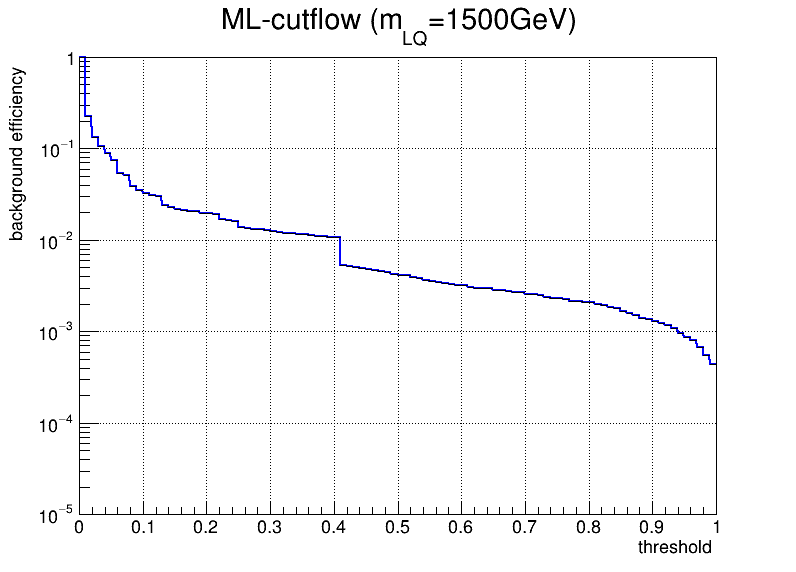

In [38]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,bkg_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;background efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.GetHistogram().SetMinimum(1e-5)
graph.GetHistogram().SetMaximum(1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


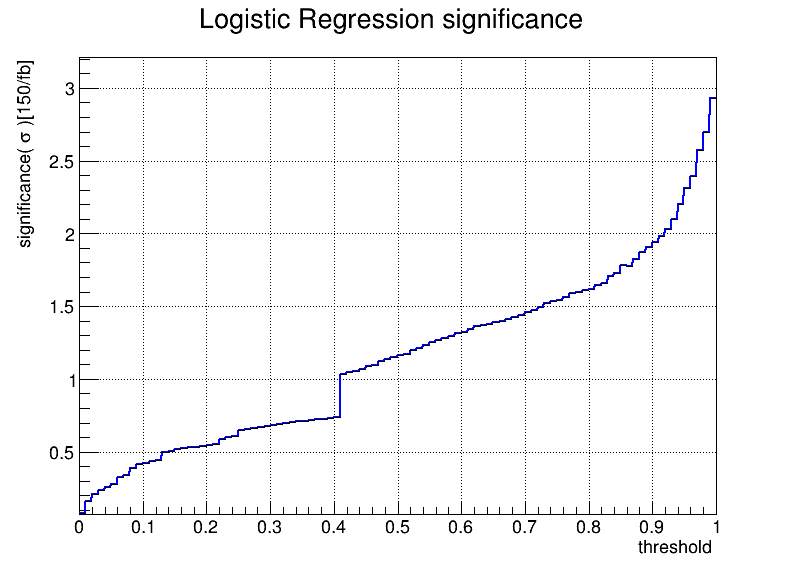

In [36]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x )
y  = np.array(  y )
c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("Logistic Regression significance;threshold;significance(#sigma )[150/fb]")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

In [37]:
x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x )
y  = np.array(  y )
print(y)

[0.07664973 0.16126944 0.20957979 0.23430197 0.25736519 0.28051854
 0.32854121 0.33811048 0.39059406 0.41147257 0.42221032 0.43304995
 0.44121744 0.49430223 0.50560236 0.51568789 0.52380946 0.52923768
 0.53413717 0.54185797 0.54629465 0.55339216 0.58816139 0.59734001
 0.60583602 0.64780631 0.65465354 0.66172259 0.66930084 0.66930084
 0.68512506 0.69035225 0.69492922 0.70228648 0.70857213 0.71186171
 0.71536556 0.72132207 0.72566899 0.73170894 0.73624755 1.03377645
 1.04669591 1.05684527 1.07009776 1.08856896 1.09756307 1.121385
 1.1345627  1.14960878 1.16381954 1.17408657 1.19861318 1.21228447
 1.23585885 1.25356544 1.26735643 1.28258045 1.28258045 1.31684231
 1.32424332 1.34497847 1.36438091 1.37143201 1.37380679 1.39201975
 1.39951048 1.41226833 1.42671308 1.43886701 1.45983262 1.4743298
 1.49231006 1.52055812 1.53529729 1.54536489 1.56084469 1.58955222
 1.59511334 1.61215357 1.61795617 1.64384505 1.6604081  1.7063871
 1.7296676  1.77923817 1.77777503 1.82336626 1.86945677 1.90556889